In [1]:
import pandas as pd
import numpy as np
from scipy import signal

In [2]:
df = pd.read_csv('eeg_data_test2.csv')
df['Time_diff'] = df['Time'].diff()
intervalo_promedio = df['Time_diff'].mean()

In [3]:
fs = 1/intervalo_promedio
print(f"Frecuencia de muestreo estimada: {fs} Hz")

Frecuencia de muestreo estimada: 0.02 Hz


In [7]:
import pandas as pd
import numpy as np
from scipy import signal

# Cargar los datos capturados del archivo CSV
df = pd.read_csv('eeg_data_test2.csv')

# Frecuencia de muestreo
fs = 20  # Hz, calculada a partir de los datos (1 muestra cada 50 ms)
nyq = 0.5 * fs  # Frecuencia de Nyquist

# Función para aplicar el filtro pasa banda
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

# Aplicar filtros a todos los canales
def filtrar_eeg(df):
    # Definir las bandas de frecuencia adaptadas a la frecuencia de muestreo de 20 Hz
    delta_filt = butter_bandpass_filter(df['Channel_1'], 0.5, 4, fs)   # Ondas Delta (0.5-4 Hz)
    theta_filt = butter_bandpass_filter(df['Channel_2'], 4, 8, fs)     # Ondas Theta (4-8 Hz)
    alfa_filt = butter_bandpass_filter(df['Channel_3'], 6, 9, fs)      # Ondas Alfa ajustadas (6-9 Hz)
    
    # Asignar las señales filtradas a nuevas columnas
    df['Delta_Channel_1'] = delta_filt
    df['Theta_Channel_2'] = theta_filt
    df['Alfa_Channel_3'] = alfa_filt
    
    return df

# Aplicar los filtros
df_filtrado = filtrar_eeg(df)

# Guardar el DataFrame filtrado en un nuevo archivo CSV
df_filtrado.to_csv('eeg_data_filtrado_adaptado.csv', index=False)
print("Datos filtrados guardados en CSV")

Datos filtrados guardados en CSV


# Clasificacion Automatica usando K-Means Clustering


Cluster
0    6050
2       7
1       3
Name: count, dtype: int64
El archivo CSV ha sido guardado con suceso.


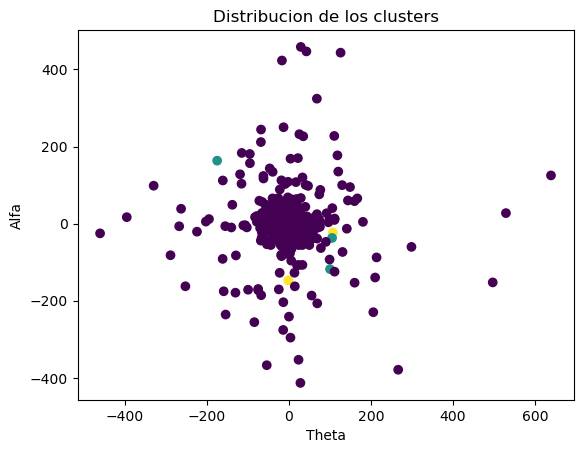

In [16]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Cargar los datos filtrados del archivo csv
df = pd.read_csv('eeg_data_filtrado_adaptado.csv')

# Seleccionar ciolumnas de las señales filtradas (Delta, Theta, Alfa) como caracteristicas para el clustering
X = df[['Delta_Channel_1', 'Theta_Channel_2', 'Alfa_Channel_3']]

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Mostrrar la distribucion de los clusters
print(df['Cluster'].value_counts())

df.to_csv('eeg_data_3clustering.csv', index=False)
print("El archivo CSV ha sido guardado con suceso.")

plt.scatter(df['Theta_Channel_2'], df['Alfa_Channel_3'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Theta')
plt.ylabel('Alfa')
plt.title('Distribucion de los clusters')
plt.show()


Cluster
 0    5860
-1     200
Name: count, dtype: int64
Datos con clustering DBSCAN guardados en CSV


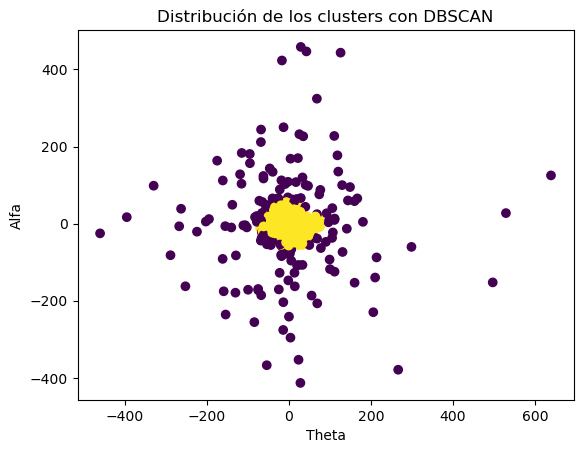

In [18]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Cargar los datos filtrados del archivo CSV
df = pd.read_csv('eeg_data_filtrado_adaptado.csv')

# Seleccionar las columnas de las señales filtradas (Delta, Theta, Alfa)
X = df[['Delta_Channel_1', 'Theta_Channel_2', 'Alfa_Channel_3']]

# Escalar los datos para mejorar el rendimiento de DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Ajusta eps y min_samples si es necesario
df['Cluster'] = dbscan.fit_predict(X_scaled)

# Mostrar la distribución de los clusters
print(df['Cluster'].value_counts())

# Guardar el archivo con los clusters asignados
df.to_csv('eeg_data_clustering_dbscan.csv', index=False)
print("Datos con clustering DBSCAN guardados en CSV")

# Visualización de los clusters
plt.scatter(df['Theta_Channel_2'], df['Alfa_Channel_3'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Theta')
plt.ylabel('Alfa')
plt.title('Distribución de los clusters con DBSCAN')
plt.show()


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Cargar los datos filtrados del archivo CSV con clustering
df = pd.read_csv('eeg_data_clustering.csv')

# Seleccionar las características (columnas con las señales EEG filtradas)
X = df[['Delta_Channel_1', 'Theta_Channel_2', 'Alfa_Channel_3']]

# Usar los clusters como las etiquetas (targets) para entrenar la red
y = df['Cluster']

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir las etiquetas a formato categórico (one-hot encoding)
y_categorical = to_categorical(y)

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

# Crear el modelo de red neuronal
model = Sequential()

# Añadir capas densas (capas ocultas)
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Capa de entrada
model.add(Dense(32, activation='relu'))  # Capa oculta 1
model.add(Dense(16, activation='relu'))  # Capa oculta 2

# Capa de salida: el número de neuronas debe coincidir con el número de clusters
model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Capa de salida (con softmax)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo
scores = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {scores[1]*100:.2f}%")

# Guardar el modelo entrenado
model.save('modelo_dnn_eeg.h5')
print("Modelo guardado como 'modelo_dnn_eeg.h5'")

2024-10-16 23:17:52.091591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 23:17:52.255076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 23:17:52.314743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 23:17:52.331661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 23:17:52.447910: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/50


/home/renzo/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1729131473.899573   61270 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 23:17:54.008445: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5999 - loss: 1.8372 - val_accuracy: 0.9035 - val_loss: 0.5311
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.9334 - loss: 0.4409 - val_accuracy: 0.9637 - val_loss: 0.1781
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.9711 - loss: 0.1647 - val_accuracy: 0.9554 - val_loss: 0.1192
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.9788 - loss: 0.1129 - val_accuracy: 0.9703 - val_loss: 0.0948
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.9874 - loss: 0.0861 - val_accuracy: 0.9818 - val_loss: 0.0795
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.9802 - loss: 0.0811 - val_accuracy: 0.9893 - val_loss: 0.0665
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.9842 - loss: 0.0708 - val_accuracy: 0.9686 - val_loss: 0.0798
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.9883 - loss: 0.0594 - val_accuracy:

Precisión en el conjunto de prueba: 98.76%
Modelo guardado como 'modelo_dnn_eeg.h5'


# Exportar modelo DNN para Android


In [21]:
import tensorflow as tf

model =tf.keras.models.load_model('modelo_dnn_eeg.h5')

convertir = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = convertir.convert()

#Guardar modelo convertido
with open('modelo_dnn_eeg.tflite', 'wb') as f:
    f.write(tflite_model)

print("Modelo exportado como 'modelo_dnn_eeg.tflite'")

INFO:tensorflow:Assets written to: /tmp/tmpzzx7oiq5/assets


INFO:tensorflow:Assets written to: /tmp/tmpzzx7oiq5/assets


Saved artifact at '/tmp/tmpzzx7oiq5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  127431945067344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127431945068688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127431945068880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127431945069648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127431945069264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127431945070416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127431945067152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127431945071184: TensorSpec(shape=(), dtype=tf.resource, name=None)
Modelo exportado como 'modelo_dnn_eeg.tflite'


W0000 00:00:1729131985.840043   61270 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1729131985.840054   61270 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-16 23:26:25.840166: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpzzx7oiq5
2024-10-16 23:26:25.840497: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-16 23:26:25.840504: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpzzx7oiq5
2024-10-16 23:26:25.843328: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-16 23:26:25.861434: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpzzx7oiq5
2024-10-16 23:26:25.866876: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 26712 microseconds.
